# Transformer, many-to-many with text
### Decoder Only Architecture

Let's revisit text generation and see how we can use Attention to create a Transformer instead of an LSTM. The type of Transformer network we will be using is called a "Decoder only" as there is no cross-attention.
We will instead be using a type of Self-Attention called "Masked Self-Attention". Similar to regular Self-Attention, "Masked Self-Attention" uses "Causal Masking" to prevent tokens from querying other tokens that are later in the input sequence.<br>
Why?
<br>
As we're doing next-token prediction, if we let a token query every token in the sequence it will be able to simply "look" at what comes next in the sequence and return exactly what comes next! This is not useful as at test time when we want it to generate text it won't be able to do that!<br>
With "Causal Masking" we simply mask-out (multiply by zero) regions of the attention map that correspond to a token querying tokens that are later in the sequence. As a result a token will only be able to query itself, or any token that came BEFORE it in the sequence!

<img src="../data/llm_architecture_comparison.png" width="600" align="center">
<br>
We don't be exactly implementing the Decoder only Transformer detailed above, our network will basically be the Decoder from the Encoder-Decoder network without the Cross-Attention (input from the Encoder).
<br>
NOTE: We will cover Encoder-Decoder networks in the next notebook!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import re
import math
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.distributions import Categorical

from torchtext.datasets import WikiText2, EnWik9, AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torch.hub import load_state_dict_from_url
from torchtext.data.functional import sentencepiece_tokenizer, load_sp_model

import warnings
import torchtext

torch.backends.cuda.matmul.allow_tf32 = True

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")


CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3090


In [2]:
# Define the hyperparameters
# Learning rate for the optimizer
learning_rate = 1e-4

# Number of epochs for training
nepochs = 100

# Batch size for data loaders
batch_size = 128

# Maximum sequence length for text inputs
max_len = 64

# Root directory of the dataset
data_set_root = "../../datasets"

## Data processing and Tokenization

In [3]:
# We'll be using the AG News Dataset
# Which contains a short news article and a single label to classify the "type" of article
# Note that for torchtext these datasets are NOT Pytorch dataset classes "AG_NEWS" is a function that
# returns a Pytorch DataPipe!

# Pytorch DataPipes vvv
# https://pytorch.org/data/main/torchdata.datapipes.iter.html

# vvv Good Blog on the difference between DataSet and DataPipe
# https://medium.com/deelvin-machine-learning/comparison-of-pytorch-dataset-and-torchdata-datapipes-486e03068c58
# Depending on the dataset sometimes the dataset doesn't download and gives an error
# and you'll have to download and extract manually 
# "The datasets supported by torchtext are datapipes from the torchdata project, which is still in Beta status"

# Un-comment to triger the DataPipe to download the data vvv
# dataset_train = YahooAnswers(root=data_set_root, split="train")
# data = next(iter(dataset_train))

# Side-Note I've noticed that the WikiText dataset is no longer able to be downloaded :(

In [3]:
import os
import urllib.request

def download_ag_news():
    # URLs for the AG News dataset
    URL = {
        'train': "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv",
        'test': "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv",
    }
    
    # Use the data_set_root variable
    ag_news_path = os.path.join(data_set_root, "datasets/AG_NEWS")
    os.makedirs(ag_news_path, exist_ok=True)
    
    for split, url in URL.items():
        file_path = os.path.join(ag_news_path, f"{split}.csv")
        if not os.path.exists(file_path):
            print(f"Downloading {split} dataset...")
            urllib.request.urlretrieve(url, file_path)
            print(f"{split.capitalize()} dataset downloaded successfully.")
        else:
            print(f"{split.capitalize()} dataset already exists.")
    
    print(f"AG News dataset is ready. Location: {ag_news_path}")

# Check if the dataset exists, if not, download it
if not os.path.exists(os.path.join(data_set_root, "datasets/AG_NEWS/train.csv")):
    download_ag_news()

In [4]:
# Un-Comment to train sentence-piece model for tokenizer and vocab!
from torchtext.data.functional import generate_sp_model

if not os.path.exists(os.path.join(data_set_root, "datasets/AG_NEWS/data.txt")):
    with open(os.path.join(data_set_root, "datasets/AG_NEWS/train.csv")) as f:
        with open(os.path.join(data_set_root, "datasets/AG_NEWS/data.txt"), "w") as f2:
            for i, line in enumerate(f):
                text_only = "".join(line.split(",")[1:])
                filtered = re.sub(r'\\|\\n|;', ' ', text_only.replace('"', ' ').replace('\n', ' ')) # remove newline characters
                filtered = filtered.replace(' #39;', "'")
                filtered = filtered.replace(' #38;', "&")
                filtered = filtered.replace(' #36;', "$")
                filtered = filtered.replace(' #151;', "-")

                f2.write(filtered.lower() + "\n")

if not os.path.exists("spm_ag_news.model"):
    generate_sp_model(os.path.join(data_set_root, "datasets/AG_NEWS/data.txt"), 
                      vocab_size=20000, model_prefix='spm_ag_news')

In [5]:
class AGNews(Dataset):
    """
    The AGNews class is a custom Dataset for handling the AG News dataset.
    This dataset consists of news articles categorized into four classes.
    The class loads the data from CSV files, preprocesses the text by cleaning and combining
    relevant columns, and provides an interface to access individual samples along with their
    corresponding class labels.
    
    Attributes:
        df (pd.DataFrame): The DataFrame containing the preprocessed dataset.
    """
    
    def __init__(self, num_datapoints, test_train="train"):
        # Load the dataset from the specified CSV file
        self.df = pd.read_csv(os.path.join(data_set_root, "datasets/AG_NEWS/" + test_train + ".csv"),
                              names=["Class", "Title", "Content"])
        
        # Fill any missing values with empty strings
        self.df.fillna('', inplace=True)
        
        # Combine the Title and Content columns into a single Article column
        self.df['Article'] = self.df['Title'] + " : " + self.df['Content']
        
        # Drop the now redundant Title and Content columns
        self.df.drop(['Title', 'Content'], axis=1, inplace=True)
        
        # Clean the Article column by removing unwanted characters and replacing HTML codes
        self.df['Article'] = self.df['Article'].str.replace(r'\\n|\\|\\r|\\r\\n|\n|"', ' ', regex=True)
        self.df['Article'] = self.df['Article'].replace({' #39;': "'", 
                                                         ' #38;': "&", 
                                                         ' #36;': "$",
                                                         ' #151;': "-"}, 
                                                        regex=True)

    def __getitem__(self, index):
        # Retrieve the article text and convert it to lowercase
        text = self.df.loc[index]["Article"].lower()

        # Return a tuple of the class index and the article text
        return text
    
    def __len__(self):
        # Return the number of data points in the dataset
        return len(self.df)

In [6]:
# Create training and testing datasets
dataset_train = AGNews(num_datapoints=data_set_root, test_train="train")
dataset_test = AGNews(num_datapoints=data_set_root, test_train="test")

# Create data loaders for the training and testing datasets
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=8)

In [7]:
def yield_tokens(file_path):
    with io.open(file_path, encoding='utf-8') as f:
        # Iterate through each line in the file
        for line in f:
            # Yield the token from the first column (split by tab)
            yield [line.split("\t")[0]]

# Build a vocabulary from the tokens yielded by the yield_tokens function
# We will also add "special" tokens that we'll use to signal something to our model
# <pad> is a padding token that is added to the end of a sentence to ensure 
# the length of all sequences in a batch is the same
# <sos> signals the "Start-Of-Sentence" aka the start of the sequence
# <eos> signal the "End-Of-Sentence" aka the end of the sequence
# <unk> "unknown" token is used if a token is not contained in the vocab
vocab = build_vocab_from_iterator(yield_tokens("spm_ag_news.vocab"), 
                                  specials=['<pad>', '<sos>', '<eos>', '<unk>'],
                                  special_first=True)

# Set the default index for unknown tokens to the index of the '<unk>' token
vocab.set_default_index(vocab['<unk>'])

In [8]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p=prob
        # to create a mask where 1 means we will replace that token
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # only replace if the token is not a special token
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [9]:
train_tranform = T.Sequential(
    # Tokeniz with pre-existing Tokenizer
    T.SentencePieceTokenizer("spm_ag_news.model"),
    ## converts the sentences to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
    # 1 as seen in previous section
    T.AddToken(1, begin=True),
    # Crop the sentance if it is longer than the max length
    T.Truncate(max_seq_len=max_len),
    ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
    # 2 as seen in previous section
    T.AddToken(2, begin=False),
    # Convert the list of lists to a tensor, this will also
    # Pad a sentence with the <pad> token if it is shorter than the max length
    # This ensures all sentences are the same length!
    T.ToTensor(padding_value=0),
)

gen_tranform = T.Sequential(
    # Tokeniz with pre-existing Tokenizer
    T.SentencePieceTokenizer("spm_ag_news.model"),
    ## converts the sentences to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
    # 1 as seen in previous section
    T.AddToken(1, begin=True),
    # Convert the list of lists to a tensor, this will also
    # Pad a sentence with the <pad> token if it is shorter than the max length
    # This ensures all sentences are the same length!
    T.ToTensor(padding_value=0)
)


In [10]:
text = next(iter(data_loader_train))
index = 0
input_tokens = train_tranform(list(text))
print("SENTENCE")
print(text[index])
print()
print("TOKENS")
print(vocab.lookup_tokens(input_tokens[index].numpy()))

SENTENCE
hamm can keep olympic all-round gold :  london (reuters) - american gymnast paul hamm will keep his  olympic all-round gold medal after the lausanne-based court of  arbitration for sport (cas) rejected an appeal from south  korea's yang tae-young.

TOKENS
['<sos>', '▁hamm', '▁can', '▁keep', '▁olympic', '▁all', '-', 'round', '▁gold', '▁:', '▁london', '▁(', 'reuters', ')', '▁-', '▁american', '▁gymnast', '▁paul', '▁hamm', '▁will', '▁keep', '▁his', '▁olympic', '▁all', '-', 'round', '▁gold', '▁medal', '▁after', '▁the', '▁lausanne', '-', 'based', '▁court', '▁of', '▁arbitration', '▁for', '▁sport', '▁(', 'ca', 's', ')', '▁rejected', '▁an', '▁appeal', '▁from', '▁south', '▁korea', "'", 's', '▁yang', '▁tae', '-', 'young', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [11]:
print("TOKENS BACK TO SENTENCE")

pred_text = "".join(vocab.lookup_tokens(input_tokens[index].numpy()))
pred_text.replace("▁", " ")

TOKENS BACK TO SENTENCE


"<sos> hamm can keep olympic all-round gold : london (reuters) - american gymnast paul hamm will keep his olympic all-round gold medal after the lausanne-based court of arbitration for sport (cas) rejected an appeal from south korea's yang tae-young.<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad>"

## Create Model

In [12]:
# Sinusoidal positional embeddings
class SinusoidalPosEmb(nn.Module):
    """
    Sinusoidal positional embeddings module.
    """

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        # Calculate sinusoidal positional embeddings
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

    
# Transformer block with Attention and causal masking
class TransformerBlock(nn.Module):
    """
    Transformer block with self-attention and causal masking.
    """

    def __init__(self, hidden_size=128, num_heads=4):
        super(TransformerBlock, self).__init__()

        # Layer normalization for input
        self.norm1 = nn.LayerNorm(hidden_size)

        # Multi-head self-attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size, 
                                                    num_heads=num_heads, 
                                                    batch_first=True,
                                                    dropout=0.1)

        # Layer normalization for attention output
        self.norm2 = nn.LayerNorm(hidden_size)

        # Feedforward neural network
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ELU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )

    def forward(self, x, padding_mask):
        # Create causal mask for Attention
        bs, l, h = x.shape
        mask = torch.triu(torch.ones(l, l, device=x.device), 1).bool()

        # Layer normalization
        norm_x = self.norm1(x)

        # Apply multi-head Attention
        x = self.multihead_attn(norm_x, norm_x, norm_x, attn_mask=mask, key_padding_mask=padding_mask)[0] + x

        # Layer normalization
        norm_x = self.norm2(x)

        # Apply feedforward neural network
        x = self.mlp(norm_x) + x
        return x

    
# "Decoder-Only" Style Transformer with Attention
class Transformer(nn.Module):
    """
    "Decoder-Only" Style Transformer with self-attention.
    """

    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Transformer, self).__init__()

        # Token embeddings
        self.embedding = nn.Embedding(num_emb, hidden_size)

        # Positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)

        # List of Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])

        # Output layer
        self.fc_out = nn.Linear(hidden_size, num_emb)

    def forward(self, input_seq):
        # Mask for padding tokens
        input_key_mask = input_seq == 0

        # Embedding input sequence
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # Add positional embeddings to token embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb

        # Pass through Transformer blocks
        for block in self.blocks:
            embs = block(embs, padding_mask=input_key_mask)

        # Output predictions
        return self.fc_out(embs)


## Initialise Model and Optimizer

In [13]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3090


In [14]:
# Check if GPU is available, set device accordingly
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

# Embedding Size
hidden_size = 256

# Number of transformer blocks
num_layers = 8

# MultiheadAttention Heads
num_heads = 8

# Create model
tf_generator = Transformer(num_emb=len(vocab), num_layers=num_layers, 
                           hidden_size=hidden_size, num_heads=num_heads).to(device)

# Initialize the optimizer with above parameters
optimizer = optim.Adam(tf_generator.parameters(), lr=learning_rate)

# Scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Define the loss function
loss_fn = nn.CrossEntropyLoss(reduction="none")

# Custom transform that will randomly replace a token with <pad>
td = TokenDrop(prob=0.2)

# Initialize training loss logger and entropy logger
training_loss_logger = []
entropy_logger = []

In [15]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in tf_generator.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 16579619 (Approximately 16 Million) Parameters!


## Training

In [18]:
for epoch in trange(0, nepochs, leave=False, desc="Epoch"):    
    tf_generator.train()
    steps = 0
    epoch_loss = 0
    for text in tqdm(data_loader_train, desc="Training", leave=False):
        # Convert text to tokenized input
        text_tokens = train_tranform(list(text)).to(device)
        bs = text_tokens.shape[0]
        
        # Randomly drop input tokens
        input_text = td(text_tokens[:, 0:-1])
        output_text = text_tokens[:, 1:]

        # Generate predictions
        with torch.amp.autocast(device_type='cuda'):
            pred = tf_generator(input_text)

        # Calculate loss with masked cross-entropy
        mask = (output_text != 0).float()
        loss = (loss_fn(pred.transpose(1, 2), output_text) * mask).sum()/mask.sum()
        
        # Backpropagation
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Log training loss and entropy
        training_loss_logger.append(loss.item())
        epoch_loss += loss.item()
        with torch.no_grad():
            dist = Categorical(logits=pred)
            entropy_logger.append(dist.entropy().mean().item())
        
        steps += 1
        if steps % 100 == 0:
            print(f"Epoch {epoch+1}, Step {steps}, Loss: {loss.item():.4f}")
    
    # Print average loss for the epoch
    print(f"Epoch {epoch+1} completed. Average Loss: {epoch_loss/len(data_loader_train):.4f}")

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 1, Step 100, Loss: 4.4691
Epoch 1, Step 200, Loss: 4.6073
Epoch 1, Step 300, Loss: 4.5853
Epoch 1, Step 400, Loss: 4.6007
Epoch 1, Step 500, Loss: 4.4790
Epoch 1, Step 600, Loss: 4.5571
Epoch 1, Step 700, Loss: 4.5147
Epoch 1, Step 800, Loss: 4.5006
Epoch 1, Step 900, Loss: 4.5285
Epoch 1 completed. Average Loss: 4.5046


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 2, Step 100, Loss: 4.4977
Epoch 2, Step 200, Loss: 4.5459
Epoch 2, Step 300, Loss: 4.1703
Epoch 2, Step 400, Loss: 4.3606
Epoch 2, Step 500, Loss: 4.3892
Epoch 2, Step 600, Loss: 4.3909
Epoch 2, Step 700, Loss: 4.4162
Epoch 2, Step 800, Loss: 4.5980
Epoch 2, Step 900, Loss: 4.4971
Epoch 2 completed. Average Loss: 4.4629


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 3, Step 100, Loss: 4.2469
Epoch 3, Step 200, Loss: 4.3599
Epoch 3, Step 300, Loss: 4.4222
Epoch 3, Step 400, Loss: 4.4837
Epoch 3, Step 500, Loss: 4.3913
Epoch 3, Step 600, Loss: 4.4834
Epoch 3, Step 700, Loss: 4.4726
Epoch 3, Step 800, Loss: 4.5067
Epoch 3, Step 900, Loss: 4.4057
Epoch 3 completed. Average Loss: 4.4226


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 4, Step 100, Loss: 4.2829
Epoch 4, Step 200, Loss: 4.4657
Epoch 4, Step 300, Loss: 4.2631
Epoch 4, Step 400, Loss: 4.4445
Epoch 4, Step 500, Loss: 4.3516
Epoch 4, Step 600, Loss: 4.3978
Epoch 4, Step 700, Loss: 4.5658
Epoch 4, Step 800, Loss: 4.5177
Epoch 4, Step 900, Loss: 4.4309
Epoch 4 completed. Average Loss: 4.3844


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 5, Step 100, Loss: 4.2450
Epoch 5, Step 200, Loss: 4.3240
Epoch 5, Step 300, Loss: 4.4946
Epoch 5, Step 400, Loss: 4.4082
Epoch 5, Step 500, Loss: 4.4496
Epoch 5, Step 600, Loss: 4.3531
Epoch 5, Step 700, Loss: 4.4205
Epoch 5, Step 800, Loss: 4.2321
Epoch 5, Step 900, Loss: 4.2705
Epoch 5 completed. Average Loss: 4.3503


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 6, Step 100, Loss: 4.2373
Epoch 6, Step 200, Loss: 4.4230
Epoch 6, Step 300, Loss: 4.4535
Epoch 6, Step 400, Loss: 4.3886
Epoch 6, Step 500, Loss: 4.3357
Epoch 6, Step 600, Loss: 4.4734
Epoch 6, Step 700, Loss: 4.2961
Epoch 6, Step 800, Loss: 4.2931
Epoch 6, Step 900, Loss: 4.2636
Epoch 6 completed. Average Loss: 4.3145


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 7, Step 100, Loss: 4.2358
Epoch 7, Step 200, Loss: 4.3515
Epoch 7, Step 300, Loss: 4.2893
Epoch 7, Step 400, Loss: 4.0995
Epoch 7, Step 500, Loss: 4.2723
Epoch 7, Step 600, Loss: 4.2497
Epoch 7, Step 700, Loss: 4.2855
Epoch 7, Step 800, Loss: 4.2723
Epoch 7, Step 900, Loss: 4.3253
Epoch 7 completed. Average Loss: 4.2839


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 8, Step 100, Loss: 4.3446
Epoch 8, Step 200, Loss: 4.1528
Epoch 8, Step 300, Loss: 4.0921
Epoch 8, Step 400, Loss: 4.1553
Epoch 8, Step 500, Loss: 4.2876
Epoch 8, Step 600, Loss: 4.2039
Epoch 8, Step 700, Loss: 4.4762
Epoch 8, Step 800, Loss: 4.3992
Epoch 8, Step 900, Loss: 4.2715
Epoch 8 completed. Average Loss: 4.2530


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 9, Step 100, Loss: 4.4095
Epoch 9, Step 200, Loss: 3.9948
Epoch 9, Step 300, Loss: 4.1811
Epoch 9, Step 400, Loss: 4.3189
Epoch 9, Step 500, Loss: 4.2440
Epoch 9, Step 600, Loss: 4.4674
Epoch 9, Step 700, Loss: 4.1593
Epoch 9, Step 800, Loss: 4.2246
Epoch 9, Step 900, Loss: 4.2434
Epoch 9 completed. Average Loss: 4.2237


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 10, Step 100, Loss: 4.2449
Epoch 10, Step 200, Loss: 4.0862
Epoch 10, Step 300, Loss: 4.1718
Epoch 10, Step 400, Loss: 4.1758
Epoch 10, Step 500, Loss: 4.1717
Epoch 10, Step 600, Loss: 4.0968
Epoch 10, Step 700, Loss: 4.2801
Epoch 10, Step 800, Loss: 4.1972
Epoch 10, Step 900, Loss: 4.3189
Epoch 10 completed. Average Loss: 4.1963


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 11, Step 100, Loss: 4.1767
Epoch 11, Step 200, Loss: 4.0280
Epoch 11, Step 300, Loss: 4.2263
Epoch 11, Step 400, Loss: 3.8682
Epoch 11, Step 500, Loss: 4.0369
Epoch 11, Step 600, Loss: 4.1444
Epoch 11, Step 700, Loss: 4.0322
Epoch 11, Step 800, Loss: 4.1326
Epoch 11, Step 900, Loss: 4.2302
Epoch 11 completed. Average Loss: 4.1677


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 12, Step 100, Loss: 4.1747
Epoch 12, Step 200, Loss: 4.0509
Epoch 12, Step 300, Loss: 4.2003
Epoch 12, Step 400, Loss: 4.2679
Epoch 12, Step 500, Loss: 4.1931
Epoch 12, Step 600, Loss: 3.9581
Epoch 12, Step 700, Loss: 4.2138
Epoch 12, Step 800, Loss: 4.2087
Epoch 12, Step 900, Loss: 4.1426
Epoch 12 completed. Average Loss: 4.1433


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 13, Step 100, Loss: 4.1326
Epoch 13, Step 200, Loss: 4.1796
Epoch 13, Step 300, Loss: 3.9138
Epoch 13, Step 400, Loss: 4.0614
Epoch 13, Step 500, Loss: 4.1068
Epoch 13, Step 600, Loss: 4.0597
Epoch 13, Step 700, Loss: 4.1395
Epoch 13, Step 800, Loss: 4.1560
Epoch 13, Step 900, Loss: 4.1843
Epoch 13 completed. Average Loss: 4.1183


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 14, Step 100, Loss: 3.9315
Epoch 14, Step 200, Loss: 4.0377
Epoch 14, Step 300, Loss: 4.0376
Epoch 14, Step 400, Loss: 4.1156
Epoch 14, Step 500, Loss: 4.1026
Epoch 14, Step 600, Loss: 4.0966
Epoch 14, Step 700, Loss: 4.0152
Epoch 14, Step 800, Loss: 4.0144
Epoch 14, Step 900, Loss: 4.0747
Epoch 14 completed. Average Loss: 4.0959


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 15, Step 100, Loss: 4.0727
Epoch 15, Step 200, Loss: 4.0055
Epoch 15, Step 300, Loss: 4.0980
Epoch 15, Step 400, Loss: 4.2710
Epoch 15, Step 500, Loss: 4.0962
Epoch 15, Step 600, Loss: 4.0570
Epoch 15, Step 700, Loss: 4.1533
Epoch 15, Step 800, Loss: 4.1588
Epoch 15, Step 900, Loss: 4.0654
Epoch 15 completed. Average Loss: 4.0734


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 16, Step 100, Loss: 4.0168
Epoch 16, Step 200, Loss: 4.0415
Epoch 16, Step 300, Loss: 4.0720
Epoch 16, Step 400, Loss: 4.2621
Epoch 16, Step 500, Loss: 3.9663
Epoch 16, Step 600, Loss: 4.0994
Epoch 16, Step 700, Loss: 4.1886
Epoch 16, Step 800, Loss: 3.8444
Epoch 16, Step 900, Loss: 4.0032
Epoch 16 completed. Average Loss: 4.0502


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 17, Step 100, Loss: 3.9971
Epoch 17, Step 200, Loss: 3.9563
Epoch 17, Step 300, Loss: 4.1620
Epoch 17, Step 400, Loss: 3.8336
Epoch 17, Step 500, Loss: 3.9952
Epoch 17, Step 600, Loss: 3.8926
Epoch 17, Step 700, Loss: 4.1976
Epoch 17, Step 800, Loss: 3.9088
Epoch 17, Step 900, Loss: 3.9013
Epoch 17 completed. Average Loss: 4.0289


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 18, Step 100, Loss: 3.9667
Epoch 18, Step 200, Loss: 3.9760
Epoch 18, Step 300, Loss: 4.0750
Epoch 18, Step 400, Loss: 3.9907
Epoch 18, Step 500, Loss: 3.9745
Epoch 18, Step 600, Loss: 4.0136
Epoch 18, Step 700, Loss: 3.9640
Epoch 18, Step 800, Loss: 3.8277
Epoch 18, Step 900, Loss: 4.0873
Epoch 18 completed. Average Loss: 4.0077


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 19, Step 100, Loss: 4.0265
Epoch 19, Step 200, Loss: 3.9167
Epoch 19, Step 300, Loss: 4.0352
Epoch 19, Step 400, Loss: 3.9568
Epoch 19, Step 500, Loss: 4.0421
Epoch 19, Step 600, Loss: 3.8488
Epoch 19, Step 700, Loss: 4.1926
Epoch 19, Step 800, Loss: 3.7665
Epoch 19, Step 900, Loss: 3.9902
Epoch 19 completed. Average Loss: 3.9893


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 20, Step 100, Loss: 3.7303
Epoch 20, Step 200, Loss: 3.8736
Epoch 20, Step 300, Loss: 3.8852
Epoch 20, Step 400, Loss: 4.0631
Epoch 20, Step 500, Loss: 4.0175
Epoch 20, Step 600, Loss: 4.0379
Epoch 20, Step 700, Loss: 3.9491
Epoch 20, Step 800, Loss: 4.0176
Epoch 20, Step 900, Loss: 3.9802
Epoch 20 completed. Average Loss: 3.9690


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 21, Step 100, Loss: 3.9172
Epoch 21, Step 200, Loss: 3.7331
Epoch 21, Step 300, Loss: 3.9648
Epoch 21, Step 400, Loss: 3.9234
Epoch 21, Step 500, Loss: 3.9123
Epoch 21, Step 600, Loss: 3.9239
Epoch 21, Step 700, Loss: 4.1121
Epoch 21, Step 800, Loss: 3.8755
Epoch 21, Step 900, Loss: 4.0793
Epoch 21 completed. Average Loss: 3.9507


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 22, Step 100, Loss: 3.9441
Epoch 22, Step 200, Loss: 3.7156
Epoch 22, Step 300, Loss: 3.9290
Epoch 22, Step 400, Loss: 3.9848
Epoch 22, Step 500, Loss: 3.8567
Epoch 22, Step 600, Loss: 4.0403
Epoch 22, Step 700, Loss: 4.0712
Epoch 22, Step 800, Loss: 3.9387
Epoch 22, Step 900, Loss: 4.0218
Epoch 22 completed. Average Loss: 3.9320


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 23, Step 100, Loss: 3.8925
Epoch 23, Step 200, Loss: 3.8596
Epoch 23, Step 300, Loss: 3.8751
Epoch 23, Step 400, Loss: 3.9104
Epoch 23, Step 500, Loss: 3.9443
Epoch 23, Step 600, Loss: 3.9410
Epoch 23, Step 700, Loss: 3.8985
Epoch 23, Step 800, Loss: 3.8786
Epoch 23, Step 900, Loss: 4.0544
Epoch 23 completed. Average Loss: 3.9155


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 24, Step 100, Loss: 3.9253
Epoch 24, Step 200, Loss: 3.9068
Epoch 24, Step 300, Loss: 4.0268
Epoch 24, Step 400, Loss: 3.8341
Epoch 24, Step 500, Loss: 3.8088
Epoch 24, Step 600, Loss: 3.9107
Epoch 24, Step 700, Loss: 3.9236
Epoch 24, Step 800, Loss: 4.0059
Epoch 24, Step 900, Loss: 3.8763
Epoch 24 completed. Average Loss: 3.8972


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 25, Step 100, Loss: 3.9376
Epoch 25, Step 200, Loss: 3.7446
Epoch 25, Step 300, Loss: 4.0790
Epoch 25, Step 400, Loss: 3.7953
Epoch 25, Step 500, Loss: 3.8874
Epoch 25, Step 600, Loss: 3.8931
Epoch 25, Step 700, Loss: 3.6179
Epoch 25, Step 800, Loss: 3.8605
Epoch 25, Step 900, Loss: 3.9596
Epoch 25 completed. Average Loss: 3.8790


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 26, Step 100, Loss: 3.8047
Epoch 26, Step 200, Loss: 3.8148
Epoch 26, Step 300, Loss: 4.0124
Epoch 26, Step 400, Loss: 3.8511
Epoch 26, Step 500, Loss: 3.6483
Epoch 26, Step 600, Loss: 3.9846
Epoch 26, Step 700, Loss: 3.9333
Epoch 26, Step 800, Loss: 3.8694
Epoch 26, Step 900, Loss: 3.8338
Epoch 26 completed. Average Loss: 3.8632


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 27, Step 100, Loss: 3.9107
Epoch 27, Step 200, Loss: 3.7406
Epoch 27, Step 300, Loss: 3.7076
Epoch 27, Step 400, Loss: 3.7532
Epoch 27, Step 500, Loss: 4.0200
Epoch 27, Step 600, Loss: 3.8758
Epoch 27, Step 700, Loss: 3.9770
Epoch 27, Step 800, Loss: 3.6565
Epoch 27, Step 900, Loss: 3.8665
Epoch 27 completed. Average Loss: 3.8463


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 28, Step 100, Loss: 3.6809
Epoch 28, Step 200, Loss: 3.8856
Epoch 28, Step 300, Loss: 3.8670
Epoch 28, Step 400, Loss: 3.7417
Epoch 28, Step 500, Loss: 3.8144
Epoch 28, Step 600, Loss: 3.8754
Epoch 28, Step 700, Loss: 3.8112
Epoch 28, Step 800, Loss: 3.7457
Epoch 28, Step 900, Loss: 3.9063
Epoch 28 completed. Average Loss: 3.8320


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 29, Step 100, Loss: 3.7287
Epoch 29, Step 200, Loss: 3.7228
Epoch 29, Step 300, Loss: 3.5638
Epoch 29, Step 400, Loss: 3.9317
Epoch 29, Step 500, Loss: 3.7567
Epoch 29, Step 600, Loss: 3.8004
Epoch 29, Step 700, Loss: 3.8147
Epoch 29, Step 800, Loss: 3.9825
Epoch 29, Step 900, Loss: 3.6847
Epoch 29 completed. Average Loss: 3.8174


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 30, Step 100, Loss: 3.6830
Epoch 30, Step 200, Loss: 3.7522
Epoch 30, Step 300, Loss: 3.8279
Epoch 30, Step 400, Loss: 3.8449
Epoch 30, Step 500, Loss: 3.7465
Epoch 30, Step 600, Loss: 3.8062
Epoch 30, Step 700, Loss: 3.5879
Epoch 30, Step 800, Loss: 3.8196
Epoch 30, Step 900, Loss: 3.7850
Epoch 30 completed. Average Loss: 3.8024


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 31, Step 100, Loss: 3.8014
Epoch 31, Step 200, Loss: 3.7266
Epoch 31, Step 300, Loss: 3.7430
Epoch 31, Step 400, Loss: 3.7254
Epoch 31, Step 500, Loss: 3.5940
Epoch 31, Step 600, Loss: 3.8418
Epoch 31, Step 700, Loss: 3.8892
Epoch 31, Step 800, Loss: 3.7283
Epoch 31, Step 900, Loss: 3.8645
Epoch 31 completed. Average Loss: 3.7869


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 32, Step 100, Loss: 3.7261
Epoch 32, Step 200, Loss: 3.6247
Epoch 32, Step 300, Loss: 3.7151
Epoch 32, Step 400, Loss: 3.5933
Epoch 32, Step 500, Loss: 3.6745
Epoch 32, Step 600, Loss: 3.8298
Epoch 32, Step 700, Loss: 3.8519
Epoch 32, Step 800, Loss: 3.8582
Epoch 32, Step 900, Loss: 3.7321
Epoch 32 completed. Average Loss: 3.7724


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 33, Step 100, Loss: 3.8860
Epoch 33, Step 200, Loss: 3.7053
Epoch 33, Step 300, Loss: 3.8289
Epoch 33, Step 400, Loss: 3.7720
Epoch 33, Step 500, Loss: 3.8815
Epoch 33, Step 600, Loss: 3.6864
Epoch 33, Step 700, Loss: 3.6481
Epoch 33, Step 800, Loss: 3.8335
Epoch 33, Step 900, Loss: 3.7944
Epoch 33 completed. Average Loss: 3.7588


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 34, Step 100, Loss: 3.7055
Epoch 34, Step 200, Loss: 3.7428
Epoch 34, Step 300, Loss: 3.6965
Epoch 34, Step 400, Loss: 3.7163
Epoch 34, Step 500, Loss: 3.9326
Epoch 34, Step 600, Loss: 3.8632
Epoch 34, Step 700, Loss: 3.7500
Epoch 34, Step 800, Loss: 3.7199
Epoch 34, Step 900, Loss: 3.8296
Epoch 34 completed. Average Loss: 3.7452


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 35, Step 100, Loss: 3.7640
Epoch 35, Step 200, Loss: 3.5691
Epoch 35, Step 300, Loss: 3.6352
Epoch 35, Step 400, Loss: 3.7740
Epoch 35, Step 500, Loss: 3.5817
Epoch 35, Step 600, Loss: 3.9366
Epoch 35, Step 700, Loss: 3.8298
Epoch 35, Step 800, Loss: 3.6183
Epoch 35, Step 900, Loss: 3.7738
Epoch 35 completed. Average Loss: 3.7324


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 36, Step 100, Loss: 3.7023
Epoch 36, Step 200, Loss: 3.7149
Epoch 36, Step 300, Loss: 3.8617
Epoch 36, Step 400, Loss: 3.8536
Epoch 36, Step 500, Loss: 3.6596
Epoch 36, Step 600, Loss: 3.6499
Epoch 36, Step 700, Loss: 3.6180
Epoch 36, Step 800, Loss: 3.8058
Epoch 36, Step 900, Loss: 3.8227
Epoch 36 completed. Average Loss: 3.7177


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 37, Step 100, Loss: 3.6871
Epoch 37, Step 200, Loss: 3.6497
Epoch 37, Step 300, Loss: 3.8645
Epoch 37, Step 400, Loss: 3.6579
Epoch 37, Step 500, Loss: 3.7584
Epoch 37, Step 600, Loss: 3.7806
Epoch 37, Step 700, Loss: 3.7536
Epoch 37, Step 800, Loss: 3.6994
Epoch 37, Step 900, Loss: 3.6086
Epoch 37 completed. Average Loss: 3.7069


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 38, Step 100, Loss: 3.7026
Epoch 38, Step 200, Loss: 3.6754
Epoch 38, Step 300, Loss: 3.6722
Epoch 38, Step 400, Loss: 3.6677
Epoch 38, Step 500, Loss: 3.6672
Epoch 38, Step 600, Loss: 3.6440
Epoch 38, Step 700, Loss: 3.7454
Epoch 38, Step 800, Loss: 3.6089
Epoch 38, Step 900, Loss: 3.7469
Epoch 38 completed. Average Loss: 3.6925


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 39, Step 100, Loss: 3.8094
Epoch 39, Step 200, Loss: 3.6073
Epoch 39, Step 300, Loss: 3.6558
Epoch 39, Step 400, Loss: 3.7074
Epoch 39, Step 500, Loss: 3.5303
Epoch 39, Step 600, Loss: 3.7083
Epoch 39, Step 700, Loss: 3.8314
Epoch 39, Step 800, Loss: 3.6676
Epoch 39, Step 900, Loss: 3.6459
Epoch 39 completed. Average Loss: 3.6814


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 40, Step 100, Loss: 3.6287
Epoch 40, Step 200, Loss: 3.6288
Epoch 40, Step 300, Loss: 3.7125
Epoch 40, Step 400, Loss: 3.5949
Epoch 40, Step 500, Loss: 3.5818
Epoch 40, Step 600, Loss: 3.6716
Epoch 40, Step 700, Loss: 3.6829
Epoch 40, Step 800, Loss: 3.6885
Epoch 40, Step 900, Loss: 3.7345
Epoch 40 completed. Average Loss: 3.6690


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 41, Step 100, Loss: 3.7241
Epoch 41, Step 200, Loss: 3.4371
Epoch 41, Step 300, Loss: 3.5633
Epoch 41, Step 400, Loss: 3.5450
Epoch 41, Step 500, Loss: 3.7510
Epoch 41, Step 600, Loss: 3.7097
Epoch 41, Step 700, Loss: 3.6989
Epoch 41, Step 800, Loss: 3.5273
Epoch 41, Step 900, Loss: 3.8256
Epoch 41 completed. Average Loss: 3.6572


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 42, Step 100, Loss: 3.6048
Epoch 42, Step 200, Loss: 3.5122
Epoch 42, Step 300, Loss: 3.6017
Epoch 42, Step 400, Loss: 3.8150
Epoch 42, Step 500, Loss: 3.6670
Epoch 42, Step 600, Loss: 3.8251
Epoch 42, Step 700, Loss: 3.7234
Epoch 42, Step 800, Loss: 3.6445
Epoch 42, Step 900, Loss: 3.5717
Epoch 42 completed. Average Loss: 3.6478


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 43, Step 100, Loss: 3.7545
Epoch 43, Step 200, Loss: 3.5681
Epoch 43, Step 300, Loss: 3.6909
Epoch 43, Step 400, Loss: 3.5603
Epoch 43, Step 500, Loss: 3.5988
Epoch 43, Step 600, Loss: 3.7511
Epoch 43, Step 700, Loss: 3.7555
Epoch 43, Step 800, Loss: 3.6890
Epoch 43, Step 900, Loss: 3.6749
Epoch 43 completed. Average Loss: 3.6345


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 44, Step 100, Loss: 3.6276
Epoch 44, Step 200, Loss: 3.6565
Epoch 44, Step 300, Loss: 3.7417
Epoch 44, Step 400, Loss: 3.6515
Epoch 44, Step 500, Loss: 3.6008
Epoch 44, Step 600, Loss: 3.5678
Epoch 44, Step 700, Loss: 3.6659
Epoch 44, Step 800, Loss: 3.6735
Epoch 44, Step 900, Loss: 3.6208
Epoch 44 completed. Average Loss: 3.6227


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 45, Step 100, Loss: 3.6425
Epoch 45, Step 200, Loss: 3.5177
Epoch 45, Step 300, Loss: 3.6023
Epoch 45, Step 400, Loss: 3.6216
Epoch 45, Step 500, Loss: 3.6113
Epoch 45, Step 600, Loss: 3.5520
Epoch 45, Step 700, Loss: 3.6390
Epoch 45, Step 800, Loss: 3.5940
Epoch 45, Step 900, Loss: 3.6321
Epoch 45 completed. Average Loss: 3.6128


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 46, Step 100, Loss: 3.5005
Epoch 46, Step 200, Loss: 3.6391
Epoch 46, Step 300, Loss: 3.6186
Epoch 46, Step 400, Loss: 3.5472
Epoch 46, Step 500, Loss: 3.7438
Epoch 46, Step 600, Loss: 3.6065
Epoch 46, Step 700, Loss: 3.6558
Epoch 46, Step 800, Loss: 3.5805
Epoch 46, Step 900, Loss: 3.7071
Epoch 46 completed. Average Loss: 3.6020


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 47, Step 100, Loss: 3.6513
Epoch 47, Step 200, Loss: 3.5913
Epoch 47, Step 300, Loss: 3.6758
Epoch 47, Step 400, Loss: 3.5551
Epoch 47, Step 500, Loss: 3.8516
Epoch 47, Step 600, Loss: 3.5608
Epoch 47, Step 700, Loss: 3.5592
Epoch 47, Step 800, Loss: 3.6122
Epoch 47, Step 900, Loss: 3.8000
Epoch 47 completed. Average Loss: 3.5918


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 48, Step 100, Loss: 3.5814
Epoch 48, Step 200, Loss: 3.7005
Epoch 48, Step 300, Loss: 3.5191
Epoch 48, Step 400, Loss: 3.4814
Epoch 48, Step 500, Loss: 3.5557
Epoch 48, Step 600, Loss: 3.6241
Epoch 48, Step 700, Loss: 3.5251
Epoch 48, Step 800, Loss: 3.6264
Epoch 48, Step 900, Loss: 3.5594
Epoch 48 completed. Average Loss: 3.5818


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 49, Step 100, Loss: 3.6225
Epoch 49, Step 200, Loss: 3.6187
Epoch 49, Step 300, Loss: 3.6254
Epoch 49, Step 400, Loss: 3.4575
Epoch 49, Step 500, Loss: 3.6082
Epoch 49, Step 600, Loss: 3.6075
Epoch 49, Step 700, Loss: 3.6885
Epoch 49, Step 800, Loss: 3.5588
Epoch 49, Step 900, Loss: 3.5438
Epoch 49 completed. Average Loss: 3.5725


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 50, Step 100, Loss: 3.4613
Epoch 50, Step 200, Loss: 3.5940
Epoch 50, Step 300, Loss: 3.6205
Epoch 50, Step 400, Loss: 3.4828
Epoch 50, Step 500, Loss: 3.6431
Epoch 50, Step 600, Loss: 3.7140
Epoch 50, Step 700, Loss: 3.5761
Epoch 50, Step 800, Loss: 3.6805
Epoch 50, Step 900, Loss: 3.6218
Epoch 50 completed. Average Loss: 3.5619


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 51, Step 100, Loss: 3.5141
Epoch 51, Step 200, Loss: 3.5397
Epoch 51, Step 300, Loss: 3.4516
Epoch 51, Step 400, Loss: 3.5650
Epoch 51, Step 500, Loss: 3.5614
Epoch 51, Step 600, Loss: 3.5328
Epoch 51, Step 700, Loss: 3.5309
Epoch 51, Step 800, Loss: 3.4980
Epoch 51, Step 900, Loss: 3.5983
Epoch 51 completed. Average Loss: 3.5509


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 52, Step 100, Loss: 3.6014
Epoch 52, Step 200, Loss: 3.5371
Epoch 52, Step 300, Loss: 3.4060
Epoch 52, Step 400, Loss: 3.4184
Epoch 52, Step 500, Loss: 3.4569
Epoch 52, Step 600, Loss: 3.6199
Epoch 52, Step 700, Loss: 3.4843
Epoch 52, Step 800, Loss: 3.4764
Epoch 52, Step 900, Loss: 3.5050
Epoch 52 completed. Average Loss: 3.5432


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 53, Step 100, Loss: 3.3920
Epoch 53, Step 200, Loss: 3.4491
Epoch 53, Step 300, Loss: 3.5011
Epoch 53, Step 400, Loss: 3.5134
Epoch 53, Step 500, Loss: 3.5179
Epoch 53, Step 600, Loss: 3.4103
Epoch 53, Step 700, Loss: 3.6166
Epoch 53, Step 800, Loss: 3.6002
Epoch 53, Step 900, Loss: 3.6091
Epoch 53 completed. Average Loss: 3.5300


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 54, Step 100, Loss: 3.3569
Epoch 54, Step 200, Loss: 3.5182
Epoch 54, Step 300, Loss: 3.6195
Epoch 54, Step 400, Loss: 3.5432
Epoch 54, Step 500, Loss: 3.4540
Epoch 54, Step 600, Loss: 3.4412
Epoch 54, Step 700, Loss: 3.5687
Epoch 54, Step 800, Loss: 3.7149
Epoch 54, Step 900, Loss: 3.5169
Epoch 54 completed. Average Loss: 3.5235


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 55, Step 100, Loss: 3.4994
Epoch 55, Step 200, Loss: 3.5410
Epoch 55, Step 300, Loss: 3.5409
Epoch 55, Step 400, Loss: 3.5578
Epoch 55, Step 500, Loss: 3.5180
Epoch 55, Step 600, Loss: 3.5685
Epoch 55, Step 700, Loss: 3.6501
Epoch 55, Step 800, Loss: 3.5115
Epoch 55, Step 900, Loss: 3.5712
Epoch 55 completed. Average Loss: 3.5150


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 56, Step 100, Loss: 3.4142
Epoch 56, Step 200, Loss: 3.5570
Epoch 56, Step 300, Loss: 3.4148
Epoch 56, Step 400, Loss: 3.6720
Epoch 56, Step 500, Loss: 3.5382
Epoch 56, Step 600, Loss: 3.4150
Epoch 56, Step 700, Loss: 3.4449
Epoch 56, Step 800, Loss: 3.5667
Epoch 56, Step 900, Loss: 3.7079
Epoch 56 completed. Average Loss: 3.5057


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 57, Step 100, Loss: 3.4633
Epoch 57, Step 200, Loss: 3.3088
Epoch 57, Step 300, Loss: 3.5048
Epoch 57, Step 400, Loss: 3.6084
Epoch 57, Step 500, Loss: 3.5271
Epoch 57, Step 600, Loss: 3.5133
Epoch 57, Step 700, Loss: 3.5581
Epoch 57, Step 800, Loss: 3.4274
Epoch 57, Step 900, Loss: 3.5072
Epoch 57 completed. Average Loss: 3.4978


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 58, Step 100, Loss: 3.5012
Epoch 58, Step 200, Loss: 3.3774
Epoch 58, Step 300, Loss: 3.5580
Epoch 58, Step 400, Loss: 3.5737
Epoch 58, Step 500, Loss: 3.4687
Epoch 58, Step 600, Loss: 3.6037
Epoch 58, Step 700, Loss: 3.4616
Epoch 58, Step 800, Loss: 3.4706
Epoch 58, Step 900, Loss: 3.7048
Epoch 58 completed. Average Loss: 3.4879


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 59, Step 100, Loss: 3.5300
Epoch 59, Step 200, Loss: 3.4794
Epoch 59, Step 300, Loss: 3.4710
Epoch 59, Step 400, Loss: 3.5294
Epoch 59, Step 500, Loss: 3.5148
Epoch 59, Step 600, Loss: 3.4797
Epoch 59, Step 700, Loss: 3.5230
Epoch 59, Step 800, Loss: 3.5646
Epoch 59, Step 900, Loss: 3.3725
Epoch 59 completed. Average Loss: 3.4797


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 60, Step 100, Loss: 3.2972
Epoch 60, Step 200, Loss: 3.4961
Epoch 60, Step 300, Loss: 3.4990
Epoch 60, Step 400, Loss: 3.5404
Epoch 60, Step 500, Loss: 3.4818
Epoch 60, Step 600, Loss: 3.1145
Epoch 60, Step 700, Loss: 3.4910
Epoch 60, Step 800, Loss: 3.5150
Epoch 60, Step 900, Loss: 3.4903
Epoch 60 completed. Average Loss: 3.4725


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 61, Step 100, Loss: 3.5304
Epoch 61, Step 200, Loss: 3.3512
Epoch 61, Step 300, Loss: 3.3975
Epoch 61, Step 400, Loss: 3.4658
Epoch 61, Step 500, Loss: 3.4852
Epoch 61, Step 600, Loss: 3.4413
Epoch 61, Step 700, Loss: 3.4824
Epoch 61, Step 800, Loss: 3.4765
Epoch 61, Step 900, Loss: 3.4591
Epoch 61 completed. Average Loss: 3.4607


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 62, Step 100, Loss: 3.5204
Epoch 62, Step 200, Loss: 3.3539
Epoch 62, Step 300, Loss: 3.4270
Epoch 62, Step 400, Loss: 3.5011
Epoch 62, Step 500, Loss: 3.4738
Epoch 62, Step 600, Loss: 3.3427
Epoch 62, Step 700, Loss: 3.5308
Epoch 62, Step 800, Loss: 3.4807
Epoch 62, Step 900, Loss: 3.5794
Epoch 62 completed. Average Loss: 3.4540


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 63, Step 100, Loss: 3.4705
Epoch 63, Step 200, Loss: 3.5428
Epoch 63, Step 300, Loss: 3.4627
Epoch 63, Step 400, Loss: 3.4172
Epoch 63, Step 500, Loss: 3.5991
Epoch 63, Step 600, Loss: 3.5264
Epoch 63, Step 700, Loss: 3.4439
Epoch 63, Step 800, Loss: 3.4262
Epoch 63, Step 900, Loss: 3.3178
Epoch 63 completed. Average Loss: 3.4466


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 64, Step 100, Loss: 3.3616
Epoch 64, Step 200, Loss: 3.3029
Epoch 64, Step 300, Loss: 3.4820
Epoch 64, Step 400, Loss: 3.4249
Epoch 64, Step 500, Loss: 3.5114
Epoch 64, Step 600, Loss: 3.3527
Epoch 64, Step 700, Loss: 3.5293
Epoch 64, Step 800, Loss: 3.4721
Epoch 64, Step 900, Loss: 3.4576
Epoch 64 completed. Average Loss: 3.4390


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 65, Step 100, Loss: 3.3372
Epoch 65, Step 200, Loss: 3.4083
Epoch 65, Step 300, Loss: 3.4246
Epoch 65, Step 400, Loss: 3.5398
Epoch 65, Step 500, Loss: 3.5764
Epoch 65, Step 600, Loss: 3.4920
Epoch 65, Step 700, Loss: 3.5715
Epoch 65, Step 800, Loss: 3.2361
Epoch 65, Step 900, Loss: 3.4503
Epoch 65 completed. Average Loss: 3.4329


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 66, Step 100, Loss: 3.3406
Epoch 66, Step 200, Loss: 3.3404
Epoch 66, Step 300, Loss: 3.2613
Epoch 66, Step 400, Loss: 3.2700
Epoch 66, Step 500, Loss: 3.4852
Epoch 66, Step 600, Loss: 3.6047
Epoch 66, Step 700, Loss: 3.5890
Epoch 66, Step 800, Loss: 3.4495
Epoch 66, Step 900, Loss: 3.5608
Epoch 66 completed. Average Loss: 3.4249


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 67, Step 100, Loss: 3.4779
Epoch 67, Step 200, Loss: 3.3926
Epoch 67, Step 300, Loss: 3.4746
Epoch 67, Step 400, Loss: 3.4097
Epoch 67, Step 500, Loss: 3.4774
Epoch 67, Step 600, Loss: 3.3868
Epoch 67, Step 700, Loss: 3.4581
Epoch 67, Step 800, Loss: 3.4997
Epoch 67, Step 900, Loss: 3.3697
Epoch 67 completed. Average Loss: 3.4158


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 68, Step 100, Loss: 3.4653
Epoch 68, Step 200, Loss: 3.2794
Epoch 68, Step 300, Loss: 3.4147
Epoch 68, Step 400, Loss: 3.4756
Epoch 68, Step 500, Loss: 3.3978
Epoch 68, Step 600, Loss: 3.5100
Epoch 68, Step 700, Loss: 3.4716
Epoch 68, Step 800, Loss: 3.3546
Epoch 68, Step 900, Loss: 3.5100
Epoch 68 completed. Average Loss: 3.4090


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 69, Step 100, Loss: 3.3338
Epoch 69, Step 200, Loss: 3.3954
Epoch 69, Step 300, Loss: 3.3670
Epoch 69, Step 400, Loss: 3.2983
Epoch 69, Step 500, Loss: 3.5505
Epoch 69, Step 600, Loss: 3.3953
Epoch 69, Step 700, Loss: 3.3606
Epoch 69, Step 800, Loss: 3.4420
Epoch 69, Step 900, Loss: 3.5085
Epoch 69 completed. Average Loss: 3.4019


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 70, Step 100, Loss: 3.3328
Epoch 70, Step 200, Loss: 3.4329
Epoch 70, Step 300, Loss: 3.4055
Epoch 70, Step 400, Loss: 3.2682
Epoch 70, Step 500, Loss: 3.5216
Epoch 70, Step 600, Loss: 3.3541
Epoch 70, Step 700, Loss: 3.2921
Epoch 70, Step 800, Loss: 3.3633
Epoch 70, Step 900, Loss: 3.3255
Epoch 70 completed. Average Loss: 3.3935


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 71, Step 100, Loss: 3.4891
Epoch 71, Step 200, Loss: 3.3616
Epoch 71, Step 300, Loss: 3.2968
Epoch 71, Step 400, Loss: 3.3045
Epoch 71, Step 500, Loss: 3.4533
Epoch 71, Step 600, Loss: 3.3488
Epoch 71, Step 700, Loss: 3.3616
Epoch 71, Step 800, Loss: 3.3752
Epoch 71, Step 900, Loss: 3.4827
Epoch 71 completed. Average Loss: 3.3872


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 72, Step 100, Loss: 3.2629
Epoch 72, Step 200, Loss: 3.4170
Epoch 72, Step 300, Loss: 3.4213
Epoch 72, Step 400, Loss: 3.4266
Epoch 72, Step 500, Loss: 3.4879
Epoch 72, Step 600, Loss: 3.5375
Epoch 72, Step 700, Loss: 3.3768
Epoch 72, Step 800, Loss: 3.4361
Epoch 72, Step 900, Loss: 3.2422
Epoch 72 completed. Average Loss: 3.3819


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 73, Step 100, Loss: 3.3701
Epoch 73, Step 200, Loss: 3.3741
Epoch 73, Step 300, Loss: 3.4861
Epoch 73, Step 400, Loss: 3.4622
Epoch 73, Step 500, Loss: 3.4952
Epoch 73, Step 600, Loss: 3.3425
Epoch 73, Step 700, Loss: 3.4950
Epoch 73, Step 800, Loss: 3.4200
Epoch 73, Step 900, Loss: 3.5293
Epoch 73 completed. Average Loss: 3.3748


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 74, Step 100, Loss: 3.4298
Epoch 74, Step 200, Loss: 3.3308
Epoch 74, Step 300, Loss: 3.2449
Epoch 74, Step 400, Loss: 3.3539
Epoch 74, Step 500, Loss: 3.3313
Epoch 74, Step 600, Loss: 3.3160
Epoch 74, Step 700, Loss: 3.4210
Epoch 74, Step 800, Loss: 3.3891
Epoch 74, Step 900, Loss: 3.3588
Epoch 74 completed. Average Loss: 3.3671


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 75, Step 100, Loss: 3.5106
Epoch 75, Step 200, Loss: 3.4510
Epoch 75, Step 300, Loss: 3.2980
Epoch 75, Step 400, Loss: 3.4267
Epoch 75, Step 500, Loss: 3.2508
Epoch 75, Step 600, Loss: 3.3774
Epoch 75, Step 700, Loss: 3.3400
Epoch 75, Step 800, Loss: 3.3658
Epoch 75, Step 900, Loss: 3.3942
Epoch 75 completed. Average Loss: 3.3597


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 76, Step 100, Loss: 3.3993
Epoch 76, Step 200, Loss: 3.3680
Epoch 76, Step 300, Loss: 3.3549
Epoch 76, Step 400, Loss: 3.4377
Epoch 76, Step 500, Loss: 3.2439
Epoch 76, Step 600, Loss: 3.2718
Epoch 76, Step 700, Loss: 3.2146
Epoch 76, Step 800, Loss: 3.4981
Epoch 76, Step 900, Loss: 3.3181
Epoch 76 completed. Average Loss: 3.3532


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 77, Step 100, Loss: 3.2469
Epoch 77, Step 200, Loss: 3.2805
Epoch 77, Step 300, Loss: 3.1922
Epoch 77, Step 400, Loss: 3.3275
Epoch 77, Step 500, Loss: 3.2439
Epoch 77, Step 600, Loss: 3.3281
Epoch 77, Step 700, Loss: 3.5610
Epoch 77, Step 800, Loss: 3.3938
Epoch 77, Step 900, Loss: 3.3234
Epoch 77 completed. Average Loss: 3.3486


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 78, Step 100, Loss: 3.2670
Epoch 78, Step 200, Loss: 3.5132
Epoch 78, Step 300, Loss: 3.2947
Epoch 78, Step 400, Loss: 3.3471
Epoch 78, Step 500, Loss: 3.4152
Epoch 78, Step 600, Loss: 3.2924
Epoch 78, Step 700, Loss: 3.2901
Epoch 78, Step 800, Loss: 3.3701
Epoch 78, Step 900, Loss: 3.2625
Epoch 78 completed. Average Loss: 3.3424


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 79, Step 100, Loss: 3.1664
Epoch 79, Step 200, Loss: 3.3205
Epoch 79, Step 300, Loss: 3.2455
Epoch 79, Step 400, Loss: 3.2454
Epoch 79, Step 500, Loss: 3.5538
Epoch 79, Step 600, Loss: 3.3170
Epoch 79, Step 700, Loss: 3.3928
Epoch 79, Step 800, Loss: 3.3625
Epoch 79, Step 900, Loss: 3.1876
Epoch 79 completed. Average Loss: 3.3346


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 80, Step 100, Loss: 3.3212
Epoch 80, Step 200, Loss: 3.4291
Epoch 80, Step 300, Loss: 3.4643
Epoch 80, Step 400, Loss: 3.2428
Epoch 80, Step 500, Loss: 3.1155
Epoch 80, Step 600, Loss: 3.2610
Epoch 80, Step 700, Loss: 3.4028
Epoch 80, Step 800, Loss: 3.2078
Epoch 80, Step 900, Loss: 3.2837
Epoch 80 completed. Average Loss: 3.3279


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 81, Step 100, Loss: 3.2729
Epoch 81, Step 200, Loss: 3.3898
Epoch 81, Step 300, Loss: 3.2325
Epoch 81, Step 400, Loss: 3.3149
Epoch 81, Step 500, Loss: 3.2597
Epoch 81, Step 600, Loss: 3.3002
Epoch 81, Step 700, Loss: 3.4198
Epoch 81, Step 800, Loss: 3.2963
Epoch 81, Step 900, Loss: 3.4388
Epoch 81 completed. Average Loss: 3.3212


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 82, Step 100, Loss: 3.2584
Epoch 82, Step 200, Loss: 3.2711
Epoch 82, Step 300, Loss: 3.3199
Epoch 82, Step 400, Loss: 3.4036
Epoch 82, Step 500, Loss: 3.3060
Epoch 82, Step 600, Loss: 3.2958
Epoch 82, Step 700, Loss: 3.2347
Epoch 82, Step 800, Loss: 3.2034
Epoch 82, Step 900, Loss: 3.3812
Epoch 82 completed. Average Loss: 3.3150


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 83, Step 100, Loss: 3.2089
Epoch 83, Step 200, Loss: 3.3258
Epoch 83, Step 300, Loss: 3.1629
Epoch 83, Step 400, Loss: 3.3477
Epoch 83, Step 500, Loss: 3.3537
Epoch 83, Step 600, Loss: 3.3726
Epoch 83, Step 700, Loss: 3.3196
Epoch 83, Step 800, Loss: 3.3101
Epoch 83, Step 900, Loss: 3.1410
Epoch 83 completed. Average Loss: 3.3101


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 84, Step 100, Loss: 3.4977
Epoch 84, Step 200, Loss: 3.1617
Epoch 84, Step 300, Loss: 3.4238
Epoch 84, Step 400, Loss: 3.4064
Epoch 84, Step 500, Loss: 3.4186
Epoch 84, Step 600, Loss: 3.2355
Epoch 84, Step 700, Loss: 3.2569
Epoch 84, Step 800, Loss: 3.3505
Epoch 84, Step 900, Loss: 3.3704
Epoch 84 completed. Average Loss: 3.3054


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 85, Step 100, Loss: 3.3019
Epoch 85, Step 200, Loss: 3.2103
Epoch 85, Step 300, Loss: 3.2822
Epoch 85, Step 400, Loss: 3.2344
Epoch 85, Step 500, Loss: 3.2905
Epoch 85, Step 600, Loss: 3.2026
Epoch 85, Step 700, Loss: 3.3082
Epoch 85, Step 800, Loss: 3.2764
Epoch 85, Step 900, Loss: 3.4728
Epoch 85 completed. Average Loss: 3.2983


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 86, Step 100, Loss: 3.2051
Epoch 86, Step 200, Loss: 3.4037
Epoch 86, Step 300, Loss: 3.2339
Epoch 86, Step 400, Loss: 3.2655
Epoch 86, Step 500, Loss: 3.2231
Epoch 86, Step 600, Loss: 3.2552
Epoch 86, Step 700, Loss: 3.5088
Epoch 86, Step 800, Loss: 3.5213
Epoch 86, Step 900, Loss: 3.4002
Epoch 86 completed. Average Loss: 3.2916


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 87, Step 100, Loss: 3.3282
Epoch 87, Step 200, Loss: 3.3261
Epoch 87, Step 300, Loss: 3.3735
Epoch 87, Step 400, Loss: 3.3988
Epoch 87, Step 500, Loss: 3.2105
Epoch 87, Step 600, Loss: 3.2861
Epoch 87, Step 700, Loss: 3.2776
Epoch 87, Step 800, Loss: 3.3216
Epoch 87, Step 900, Loss: 3.2217
Epoch 87 completed. Average Loss: 3.2868


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 88, Step 100, Loss: 3.0718
Epoch 88, Step 200, Loss: 3.2509
Epoch 88, Step 300, Loss: 3.2243
Epoch 88, Step 400, Loss: 3.2995
Epoch 88, Step 500, Loss: 3.3143
Epoch 88, Step 600, Loss: 3.2965
Epoch 88, Step 700, Loss: 3.3418
Epoch 88, Step 800, Loss: 3.1493
Epoch 88, Step 900, Loss: 3.4134
Epoch 88 completed. Average Loss: 3.2817


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 89, Step 100, Loss: 3.1688
Epoch 89, Step 200, Loss: 3.3443
Epoch 89, Step 300, Loss: 3.1810
Epoch 89, Step 400, Loss: 3.1434
Epoch 89, Step 500, Loss: 3.3125
Epoch 89, Step 600, Loss: 3.3961
Epoch 89, Step 700, Loss: 3.1838
Epoch 89, Step 800, Loss: 3.3275
Epoch 89, Step 900, Loss: 3.2770
Epoch 89 completed. Average Loss: 3.2766


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 90, Step 100, Loss: 3.1899
Epoch 90, Step 200, Loss: 3.2922
Epoch 90, Step 300, Loss: 3.2110
Epoch 90, Step 400, Loss: 3.2474
Epoch 90, Step 500, Loss: 3.2629
Epoch 90, Step 600, Loss: 3.2386
Epoch 90, Step 700, Loss: 3.3892
Epoch 90, Step 800, Loss: 3.2048
Epoch 90, Step 900, Loss: 3.3231
Epoch 90 completed. Average Loss: 3.2689


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 91, Step 100, Loss: 3.1267
Epoch 91, Step 200, Loss: 3.2756
Epoch 91, Step 300, Loss: 3.2996
Epoch 91, Step 400, Loss: 3.2119
Epoch 91, Step 500, Loss: 3.2509
Epoch 91, Step 600, Loss: 3.2230
Epoch 91, Step 700, Loss: 3.2784
Epoch 91, Step 800, Loss: 3.1873
Epoch 91, Step 900, Loss: 3.2454
Epoch 91 completed. Average Loss: 3.2643


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 92, Step 100, Loss: 3.1336
Epoch 92, Step 200, Loss: 3.1840
Epoch 92, Step 300, Loss: 3.1567
Epoch 92, Step 400, Loss: 3.2225
Epoch 92, Step 500, Loss: 3.3861
Epoch 92, Step 600, Loss: 3.0911
Epoch 92, Step 700, Loss: 3.2966
Epoch 92, Step 800, Loss: 3.2480
Epoch 92, Step 900, Loss: 3.3576
Epoch 92 completed. Average Loss: 3.2604


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 93, Step 100, Loss: 3.2049
Epoch 93, Step 200, Loss: 3.2332
Epoch 93, Step 300, Loss: 3.3287
Epoch 93, Step 400, Loss: 3.2457
Epoch 93, Step 500, Loss: 3.2249
Epoch 93, Step 600, Loss: 3.3432
Epoch 93, Step 700, Loss: 3.2591
Epoch 93, Step 800, Loss: 3.3529
Epoch 93, Step 900, Loss: 3.3009
Epoch 93 completed. Average Loss: 3.2546


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 94, Step 100, Loss: 3.1204
Epoch 94, Step 200, Loss: 3.2230
Epoch 94, Step 300, Loss: 3.1369
Epoch 94, Step 400, Loss: 3.3013
Epoch 94, Step 500, Loss: 3.2447
Epoch 94, Step 600, Loss: 3.2669
Epoch 94, Step 700, Loss: 3.3769
Epoch 94, Step 800, Loss: 3.3261
Epoch 94, Step 900, Loss: 3.3561
Epoch 94 completed. Average Loss: 3.2489


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 95, Step 100, Loss: 3.2616
Epoch 95, Step 200, Loss: 3.0769
Epoch 95, Step 300, Loss: 3.1379
Epoch 95, Step 400, Loss: 3.2682
Epoch 95, Step 500, Loss: 3.2672
Epoch 95, Step 600, Loss: 3.3704
Epoch 95, Step 700, Loss: 3.2014
Epoch 95, Step 800, Loss: 3.2944
Epoch 95, Step 900, Loss: 3.2782
Epoch 95 completed. Average Loss: 3.2438


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 96, Step 100, Loss: 3.3486
Epoch 96, Step 200, Loss: 3.2368
Epoch 96, Step 300, Loss: 3.3905
Epoch 96, Step 400, Loss: 3.1862
Epoch 96, Step 500, Loss: 3.2479
Epoch 96, Step 600, Loss: 3.3961
Epoch 96, Step 700, Loss: 3.2092
Epoch 96, Step 800, Loss: 3.2057
Epoch 96, Step 900, Loss: 3.1605
Epoch 96 completed. Average Loss: 3.2397


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 97, Step 100, Loss: 3.1673
Epoch 97, Step 200, Loss: 3.1741
Epoch 97, Step 300, Loss: 3.1309
Epoch 97, Step 400, Loss: 3.2092
Epoch 97, Step 500, Loss: 3.2808
Epoch 97, Step 600, Loss: 3.2895
Epoch 97, Step 700, Loss: 3.1511
Epoch 97, Step 800, Loss: 3.1737
Epoch 97, Step 900, Loss: 3.2023
Epoch 97 completed. Average Loss: 3.2332


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 98, Step 100, Loss: 3.1719
Epoch 98, Step 200, Loss: 3.1234
Epoch 98, Step 300, Loss: 3.3345
Epoch 98, Step 400, Loss: 3.1683
Epoch 98, Step 500, Loss: 3.1999
Epoch 98, Step 600, Loss: 3.2380
Epoch 98, Step 700, Loss: 3.1587
Epoch 98, Step 800, Loss: 3.2295
Epoch 98, Step 900, Loss: 3.4091
Epoch 98 completed. Average Loss: 3.2293


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 99, Step 100, Loss: 3.2939
Epoch 99, Step 200, Loss: 3.1847
Epoch 99, Step 300, Loss: 3.2141
Epoch 99, Step 400, Loss: 3.2997
Epoch 99, Step 500, Loss: 3.1766
Epoch 99, Step 600, Loss: 3.2431
Epoch 99, Step 700, Loss: 3.2902
Epoch 99, Step 800, Loss: 3.2683
Epoch 99, Step 900, Loss: 3.2038
Epoch 99 completed. Average Loss: 3.2240


Training:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 100, Step 100, Loss: 3.2911
Epoch 100, Step 200, Loss: 3.1108
Epoch 100, Step 300, Loss: 3.2418
Epoch 100, Step 400, Loss: 3.1061
Epoch 100, Step 500, Loss: 3.2321
Epoch 100, Step 600, Loss: 3.2567
Epoch 100, Step 700, Loss: 3.4112
Epoch 100, Step 800, Loss: 3.3199
Epoch 100, Step 900, Loss: 3.1727
Epoch 100 completed. Average Loss: 3.2202


## Plot Metrics

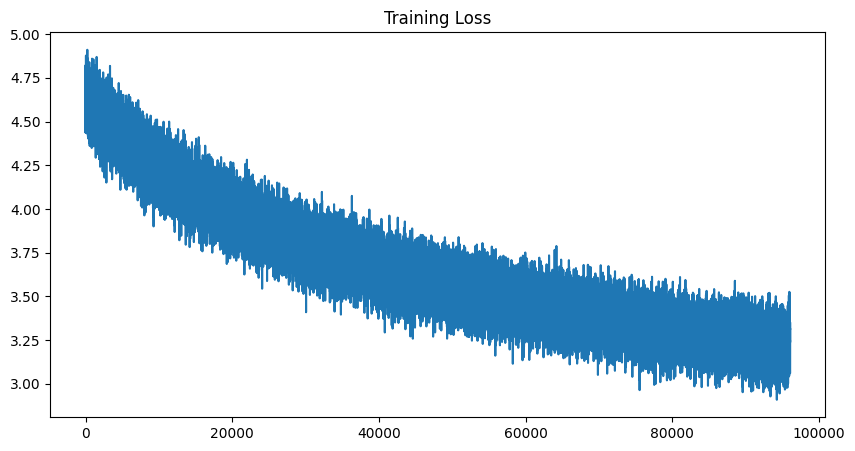

In [19]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger[10000:])
_ = plt.title("Training Loss")

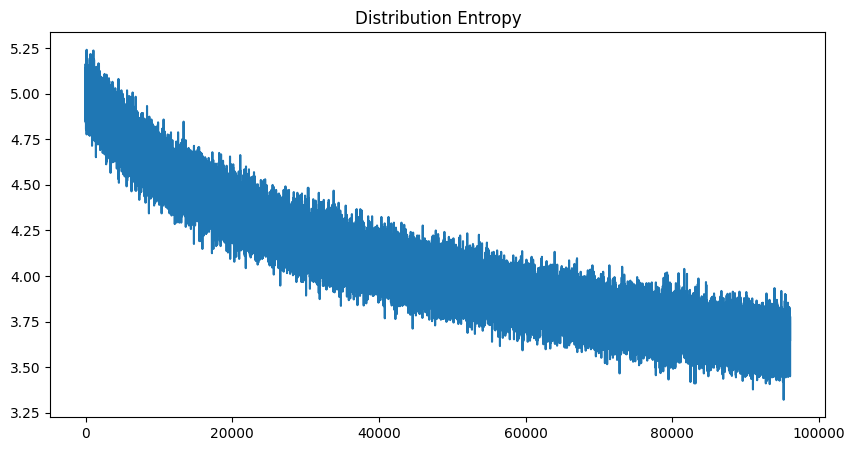

In [20]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(entropy_logger[10000:])
_ = plt.title("Distribution Entropy")

## Testing

In [21]:
# Get an example from the test set
text = next(iter(data_loader_test))

In [22]:
# Set index of the example to use
index = 0

# Set temperature for sampling
temp = 0.6

# Split text into title and content
title = text[index].split(":")[0]
init_prompt = [title + ":"]  # Create initial prompt using the title

# Extract content from text
content = text[index].split(":")[1]

# Tokenize the initial prompt
init_tokens = gen_tranform(init_prompt)

# Print initial prompt, original content, and tokenized prompt
print("INITIAL PROMPT:")
print(title)
print("")
print("ORIGINAL CONTENT:")
print(content)
print("")
print("PROMPT TOKENS:")
print(init_tokens)
print(vocab.lookup_tokens(init_tokens[0].cpu().numpy()))

INITIAL PROMPT:
exit polls

ORIGINAL CONTENT:
 hong kong democrats win limited gains 

PROMPT TOKENS:
tensor([[    1,  9286, 14917,   237]])
['<sos>', '▁exit', '▁polls', ':']


In [23]:
# List to log generated tokens
log_tokens = [init_tokens]

# Set the generator model to evaluation mode
tf_generator.eval()

# Generate tokens
with torch.no_grad():    
    for i in range(10):
        # Concatenate tokens from previous iterations
        input_tokens = torch.cat(log_tokens, 1)
        
        # Get model predictions for the next token
        data_pred = tf_generator(input_tokens.to(device))
        
        # Sample the next token from the distribution of probabilities
        dist = Categorical(logits=data_pred[:, -1] / temp)
        next_tokens = dist.sample().reshape(1, 1)
        
        # Append the sampled token to the list of generated tokens
        log_tokens.append(next_tokens.cpu())
        
        # Check for end-of-sequence token and stop generation
        if next_tokens.item() == 2:
            break

/home/ran/anaconda3/envs/linly/lib/python3.10/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


In [24]:
# Concatenate generated tokens into a single string
pred_text = "".join(vocab.lookup_tokens(torch.cat(log_tokens, 1)[0].numpy()))

# Print the generated text
print(pred_text)

<sos>▁exit▁polls:▁coors▁jones▁advances▁to▁disney▁:▁new▁york▁(reuters


In [25]:
# Replace special tokens and characters in the generated text
pred_text_cleaned = pred_text.replace("▁", " ").replace("<unk>", "").replace("<sos>", "").replace("<eos>", "")

# Print the cleaned generated text
print(pred_text_cleaned)

 exit polls: coors jones advances to disney : new york (reuters


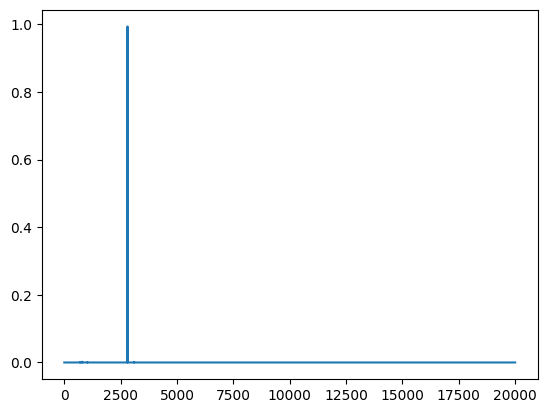

In [26]:
# Plot the softmax probabilities of the next token
_ = plt.plot(F.softmax(data_pred[0, -1] / temp, -1).cpu().numpy().flatten())